# Neural Network

In [1]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' %kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' %kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
    
    return images, labels
    
X_train, y_train = load_mnist('D:\\Workspace', kind='train')
print('training samples : %d, columns: %d' %(X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('D:\\Workspace', kind='t10k')
print('testing samples  : %d, columns: %d' %(X_test.shape[0], X_test.shape[1]))

training samples : 60000, columns: 784
testing samples  : 10000, columns: 784


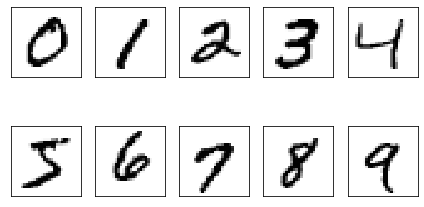

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.ravel()
for i in range(10):
    img = X_train[y_train==i][0].reshape(28,28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [4]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

class Model:
    def __init__(self, n_features: int, n_outputs: int, epochs: int, n_hiddenlayers: list=[30], minibatches=1, alpha_=0.0, eta_=1/1024, lambda_=1/8, decrease_const=1/65536, shuffle=True, random_state=None):
        np.random.seed(random_state)
        self.layers = [n_features] + n_hiddenlayers + [n_outputs]
        self.weights = []
        self.cost_ = []
        self.epochs = epochs
        self.minibatches = minibatches
        self.alpha_ = alpha_
        self.eta_ = eta_
        self.lambda_ = lambda_
        self.decrease_const = decrease_const
        self.n_features, self.n_outputs = n_features, n_outputs
        self.shuffle = shuffle
        temp = n_features + 1
        for n_units in n_hiddenlayers:
            self.weights.append(np.random.uniform(-1.0, 1.0, size=n_units*temp).reshape(n_units, temp))
            temp = n_units + 1
        self.weights.append(np.random.uniform(-1.0, 1.0, size=n_outputs*temp).reshape(n_outputs, temp))
    def _get_encoded_label(self, y: np.ndarray) -> np.ndarray:
        assert(0 <= y.all() < self.n_outputs)
        encoded = np.zeros((y.shape[0], self.n_outputs))
        for idx, val in enumerate(y):
            encoded[idx,val] = 1.0
        return encoded
    def _add_bias_units(self, x: np.ndarray):
        x_new = np.ones((x.shape[0]+1, x.shape[1]))
        x_new[1:,:] = x
        return x_new
    def _get_cost(self, y: np.ndarray, outputs: np.ndarray, weights: np.ndarray) -> float:
        cost = np.sum(-y * np.log(outputs) - (1 - y) * np.log(1 - outputs))
        for w in weights:
            cost += self.lambda_ * np.sum(w[:,1:] ** 2) / 2
        return cost / y.shape[0]
    def predict(self, _X: np.ndarray):
        units = [_X.T]
        for layer in range(len(self.layers)-1):
            units.append(sigmoid(np.matmul(self.weights[layer], self._add_bias_units(units[-1]))))
        return np.argmax(units[-1], axis=0)
    def fit(self, _X: np.ndarray, _Y: np.ndarray, print_progress: bool=True):
        assert(_X.shape[0]==_Y.shape[0])
        num = _Y.shape[0]
        X_data, Y_data = _X.copy(), self._get_encoded_label(_Y)
        eta_ = self.eta_
        delta_weight_prev = [0] * len(self.layers)
        for epoch in range(self.epochs):
            deltas = []
            for i in range(len(self.layers)-1):
                deltas.append(np.zeros(self.weights[i].shape))
            eta_ /= 1 + self.decrease_const * epoch
            if print_progress:
                os.sys.stderr.write('\rEpoch: %d/%d' %(epoch+1, self.epochs))
                os.sys.stderr.flush()
            if self.shuffle:
                idx = np.random.permutation(num)
                X_data, Y_data = X_data[idx], Y_data[idx]
            mini = np.array_split(range(_Y.shape[0]), self.minibatches)
            for idx in mini:
                x, y = X_data[idx], Y_data[idx]
                units = [x.T]
                # Perform forward propagation
                for layer in range(len(self.layers)-1):
                    units.append(sigmoid(np.matmul(self.weights[layer], self._add_bias_units(units[-1]))))
                # Update Cost
                self.cost_.append(self._get_cost(y.T, units[-1], self.weights) / len(mini))
                # Perform back propagation
                delta = units[-1] - y.T
                for i in range(len(self.layers)-2, 0, -1):
                    a = self._add_bias_units(units[i])
                    deltas[i][:,:] = deltas[i] + np.matmul(delta, a.T)
                    delta = (np.matmul(self.weights[i].T, delta) * (a * (1 - a)))[1:,:]
                a = self._add_bias_units(units[0])
                deltas[0][:,:] = deltas[0] + np.matmul(delta, a.T)
                # Update Weights
                for i, delta, theta in zip(range(len(deltas)), deltas, self.weights):
                    temp = self.lambda_ * theta
                    temp[0,:] = 0
                    grad = delta / len(mini) + temp
                    delta_cur = eta_ * grad
                    self.weights[i] -= delta_cur + self.alpha_ * delta_weight_prev[i]
                    delta_weight_prev[i] = delta_cur
        return self

In [5]:
model = Model(n_outputs=10, n_features=X_train.shape[1], n_hiddenlayers=[50], lambda_=0.1, epochs=1000, minibatches=50, random_state=1)
model.fit(X_train, y_train)


Epoch: 1/1000C:\Users\user1\AppData\Local\Temp\ipykernel_5904\2338197137.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
Epoch: 1000/1000

In [6]:
with open('model_digits.pkl', 'wb') as f:
    pickle.dump(model, f, protocol=4)
print('saved data')

saved data


In [7]:
with open('model_digits.pkl', 'rb') as f:
    model = pickle.load(f)
print('loaded data')

loaded data


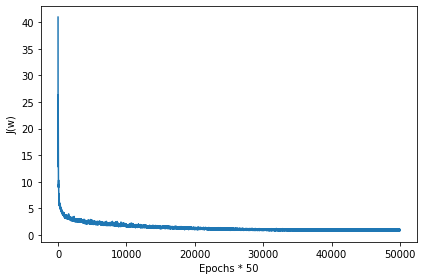

In [8]:

plt.plot(range(len(model.cost_)), model.cost_)
plt.ylabel('J(w)')
plt.xlabel('Epochs * 50')
plt.tight_layout()
plt.show()

In [9]:
y_train_pred = model.predict(X_train)
success = np.sum(y_train == y_train_pred, axis=0)
total = X_train.shape[0]
accuracy = success/total
print('success/total: [%d]/[%d]' %(success, total))
print('accuracy: %.2f%%' %(accuracy*100))

y_test_pred = model.predict(X_test)
success = np.sum(y_test == y_test_pred, axis=0)
total = X_test.shape[0]
accuracy = success/total
print('success/total: [%d]/[%d]' %(success, total))
print('accuracy: %.2f%%' %(accuracy*100))


success/total: [57624]/[60000]
accuracy: 96.04%
success/total: [9433]/[10000]
accuracy: 94.33%


C:\Users\user1\AppData\Local\Temp\ipykernel_5904\2338197137.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
